1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv") 
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df_default=pd.get_dummies(df['default'])
df_default.rename(columns={'No':'defaultN', 'Yes':'defaultY'}, inplace=True)

df_student=pd.get_dummies(df['student'])
df_student.rename(columns={'No':'studentN', 'Yes':'studentY'}, inplace=True)

df_final = pd.concat([df[['Unnamed: 0','balance','income']],df_default,df_student],axis=1)
df_final.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
print(len(df_final.ix[(df_final.defaultN == 0), ['balance', 'income', 'defaultN']]))
print(len(df_final.ix[(df_final.defaultN == 1), ['balance', 'income', 'defaultN']]))


333
9667


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

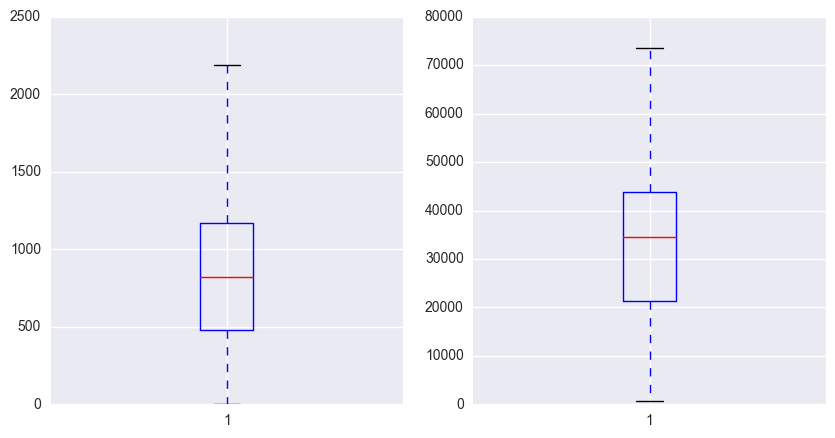

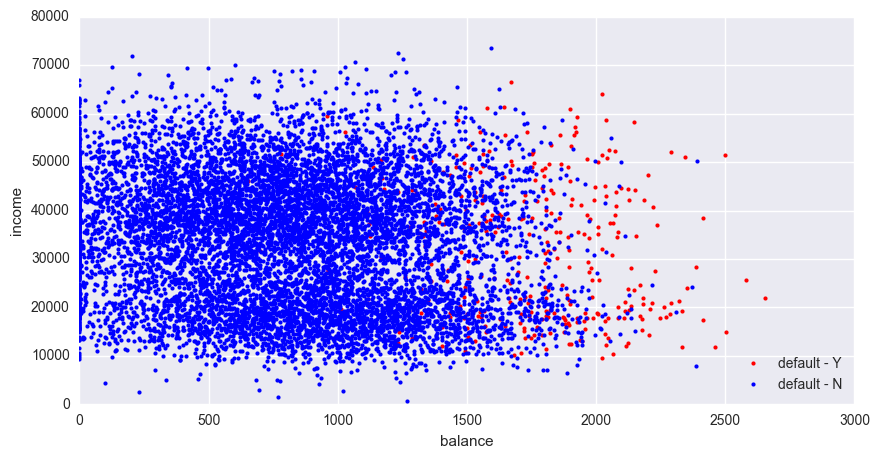

In [4]:
from itertools import cycle, islice

balance = df_final['balance']
income = df_final['income']

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(121)

axes.plot()
axes.boxplot(df_final['balance'],  0, '')

axes = fig.add_subplot(122)
axes.boxplot(df_final['income'],  0, '')

yes_def = df_final.ix[(df_final.defaultY == 1), ['balance','income'] ]
no_def  = df_final.ix[(df_final.defaultN == 1), ['balance','income'] ]

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(yes_def.balance, yes_def.income, 'ro', markersize=3, label='default - Y')
axes.plot(no_def.balance, no_def.income, 'bo', markersize=3, label = 'default - N')
axes.set_xlabel("balance")
axes.set_ylabel("income")
axes.legend(loc = 4)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

Logistic Regression using Ridge Regularization


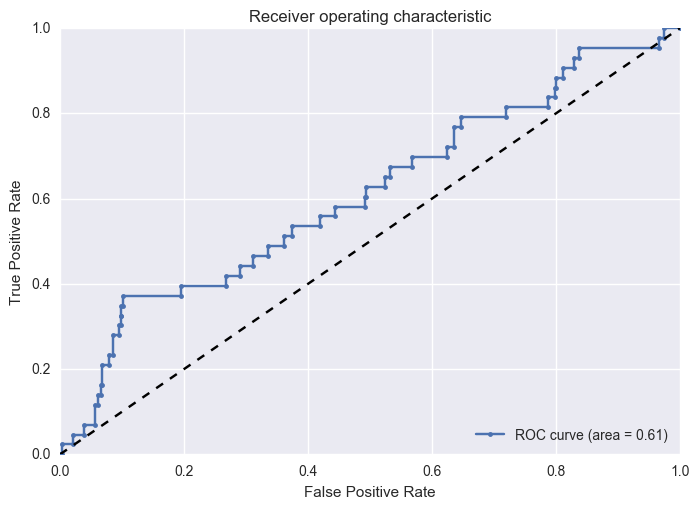

Logistic Regression using Lasso Regularization


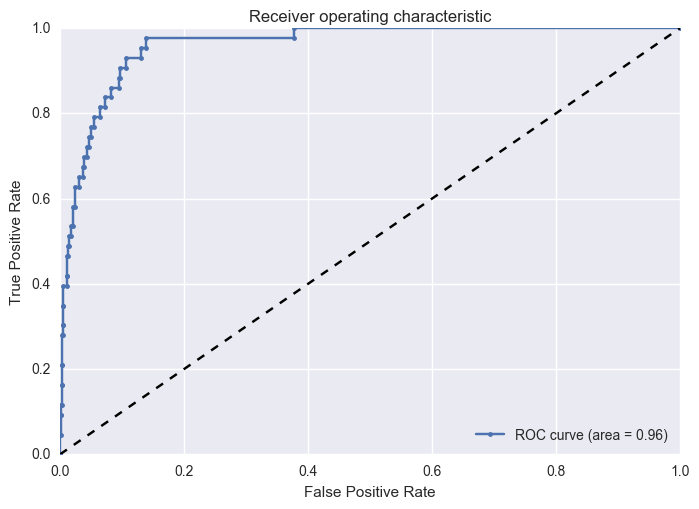

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

def rocPlot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = numpy.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]

    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds, classifier
    
X = df_final[['balance','income']]

print("Logistic Regression using Ridge Regularization")
fpr,tpr,roc_auc, thresholds, classifier= generate_auc(X, df_final.defaultY, LogisticRegression, C=50, penalty='l2')
rocPlot(fpr,tpr,'LR - Ridge Regularization',roc_auc)

print("Logistic Regression using Lasso Regularization")
fpr,tpr,roc_auc, thresholds, classifier = generate_auc(X, df_final.defaultY, LogisticRegression, C=60, penalty='l1')
rocPlot(fpr,tpr,'LR - Ridge Regularization',roc_auc)

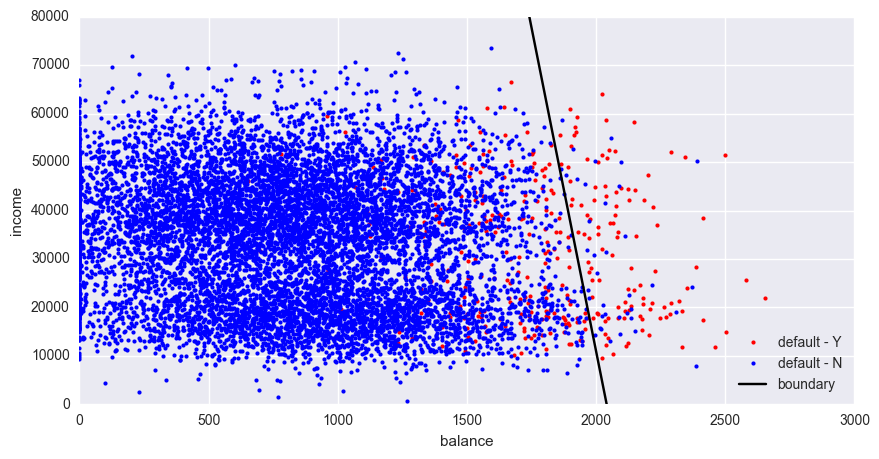

In [20]:
theta0 = classifier.intercept_
theta1, theta2 = classifier.coef_[0]
x = numpy.linspace(0, 3000, 10000)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(yes_def.balance, yes_def.income, 'ro', markersize=3, label='default - Y')
axes.plot(no_def.balance, no_def.income, 'bo', markersize=3, label = 'default - N')
axes.plot(x, (-theta0 -theta1*x)/theta2, 'k', markersize=5, label='boundary')

axes.set_ylim(0, 80000)
axes.set_xlabel("balance")
axes.set_ylabel("income")
axes.legend(loc = 4)
plt.show()

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Logistic Regression using Lasso Regularization


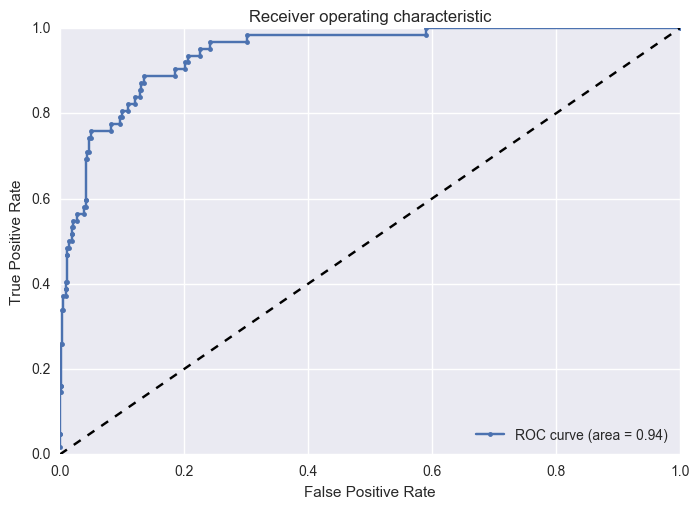

In [26]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


X = df_final[['balance', 'income', 'studentY']]
# standardize features by scaling to unit variance and removing their overall mean 
# make each individual feature look more like standard normal

scaler = StandardScaler()
X = X.as_matrix().astype(numpy.float)
X = scaler.fit_transform(X)

y = df_final.defaultY
alphas = numpy.logspace(-8, 3, 100)
score = []

random_state = numpy.random.RandomState(0)
X, y = shuffle(X, y, random_state=random_state)
n_samples, n_features = X.shape
half = int(n_samples/1.2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]

for alpha in alphas:
    classifier = Ridge(alpha=alpha)
    classifier.fit(X_train, y_train)
    score.append(classifier.score(X_test, y_test))
score = numpy.array(score)
opt_alpha = numpy.max(score)

classifier = Ridge(alpha=opt_alpha)
classifier.fit(X_train, y_train)
coef_ind = numpy.arange(n_features)

fig = plt.figure()
axes = fig.add_subplot(111)

axes.set_xticks(coef_ind)
axes.set_xticklabels(('balance', 'income', 'student - yes'))
rects = axes.patches
axes.bar(coef_ind, classifier.coef_, width=0.5)
for bar, value in zip(rects, classifier.coef_):
    numValue = bar.get_height()
    
    # put coefficient value on top of each bar by finding the (x,y) coordinate 
    # of the top of each bar in the bar graph
    axes.text(bar.get_x() + bar.get_width()/2, numValue, numpy.round(value, 5), ha='center')


print("Logistic Regression using Lasso Regularization")
fpr,tpr,roc_auc, thresholds, classifier = generate_auc(X, y, LogisticRegression, C=60, penalty='l1')
rocPlot(fpr,tpr,'LR - Ridge Regularization',roc_auc)
plt.show()


We do not see much of an improvement by adding this third variable as the area under the ROC curve stays roughly the same (around .93-.96).  

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

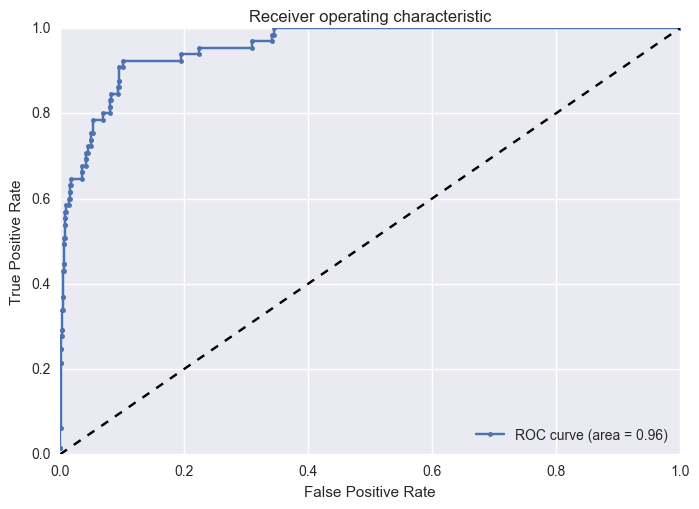

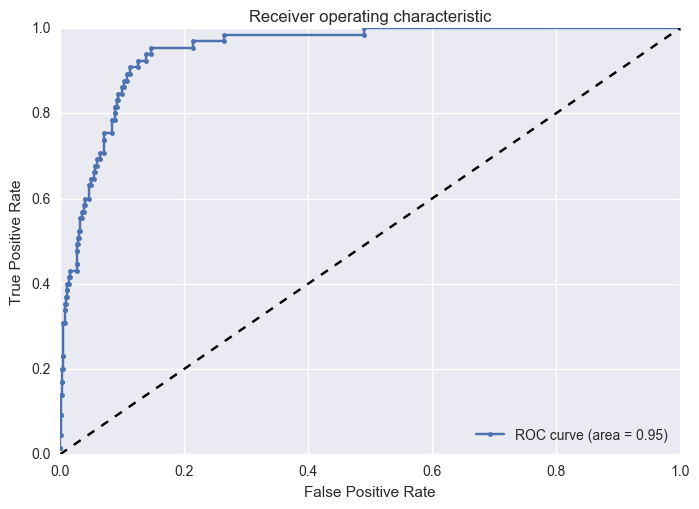

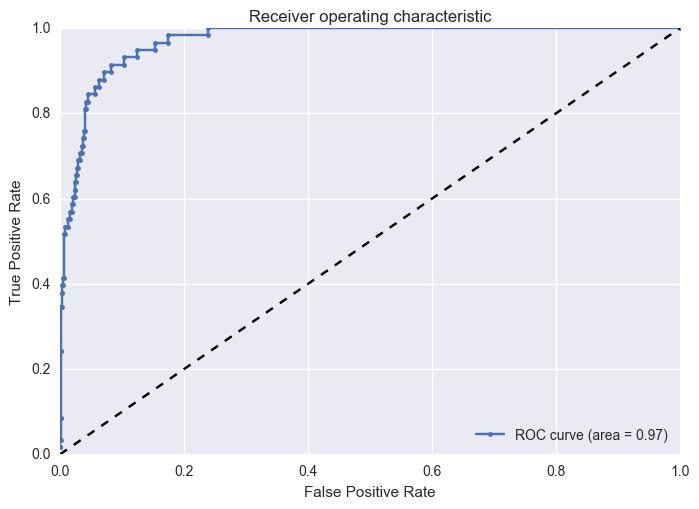

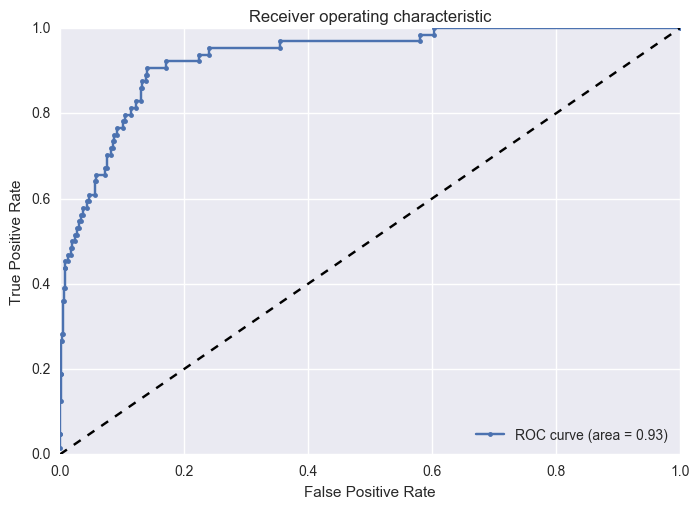

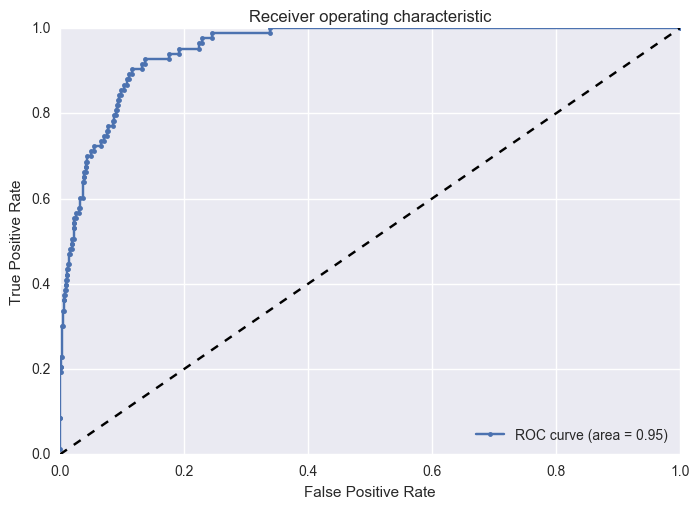

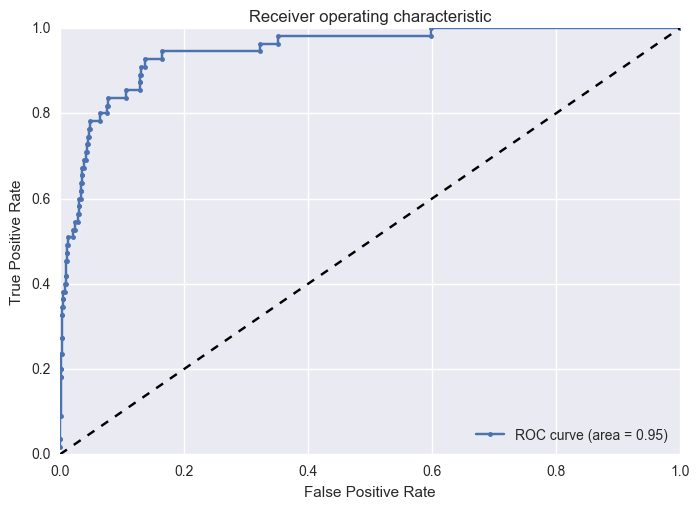

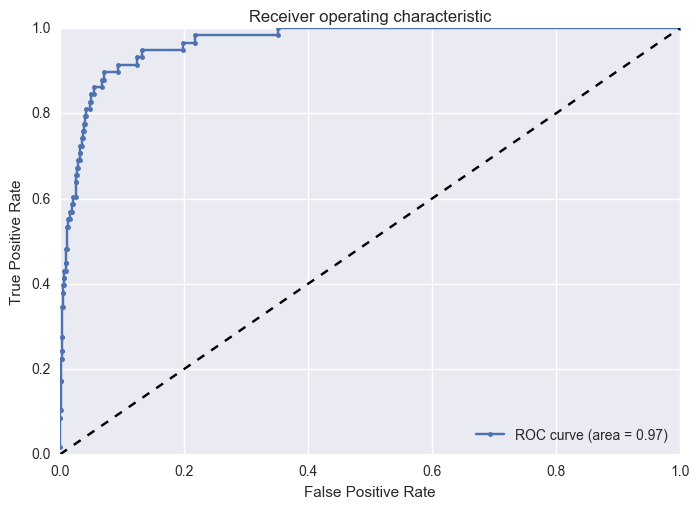

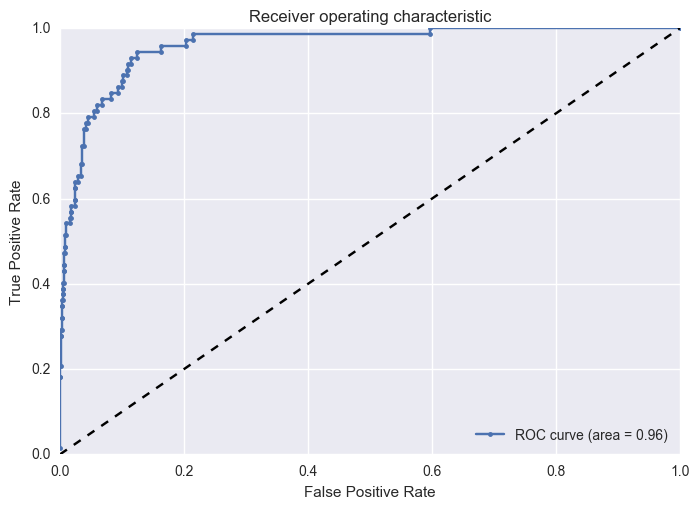

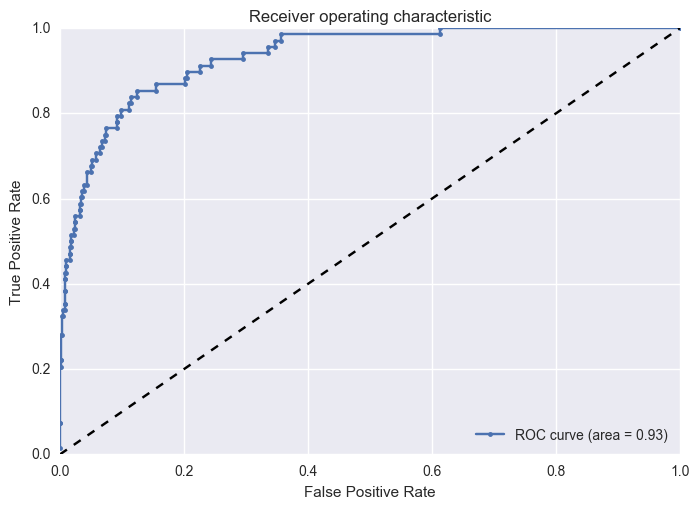

In [27]:
seeds = numpy.arange(10, 100, 10)

for seed in seeds:
    # split data, use cross validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    classifier = LogisticRegression(penalty='l1', C= 50)
    classifier.fit(X_train, y_train)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    rocPlot(fpr,tpr,'LR - Lasso Regularization',roc_auc)


We clearly have a robust model since our values for area under the ROC curve all stay within the same range (.92 - .97)

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

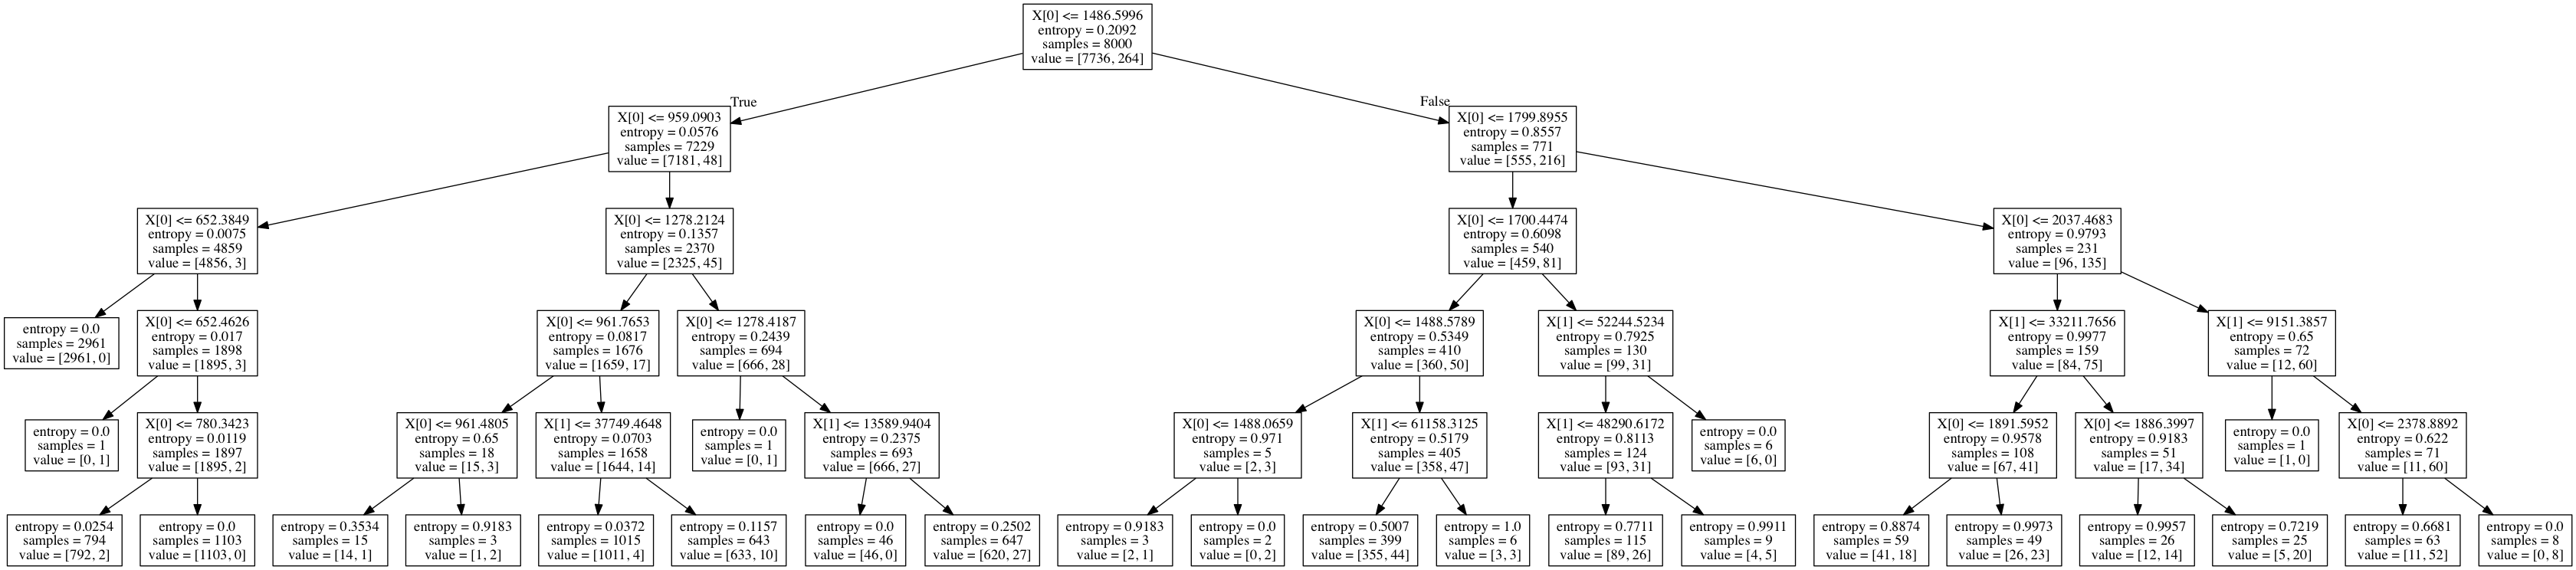

In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image  

from __future__ import print_function

import os
import subprocess
import graphviz
import pydotplus
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
X = df_final[['balance', 'income']]
y = df_final.defaultY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(criterion='entropy',  max_depth=5)
tree.fit(X_train, y_train)
visualize_tree(tree, feature_names=['x'])

dot_data=export_graphviz(tree, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

In [29]:
X = df_final[['balance', 'income']]
y = df_final.defaultY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n = 100

scores = numpy.empty(n)
depths = numpy.arange(1,n+1)
for i in range(n):
    d = depths[i]
    cfl = DecisionTreeClassifier(max_depth = d)
    cfl.fit(X_train, y_train)
    # train model 
    scores[i] = cfl.score(X_test, y_test)
    
best_depth = depths[np.argmax(scores)]


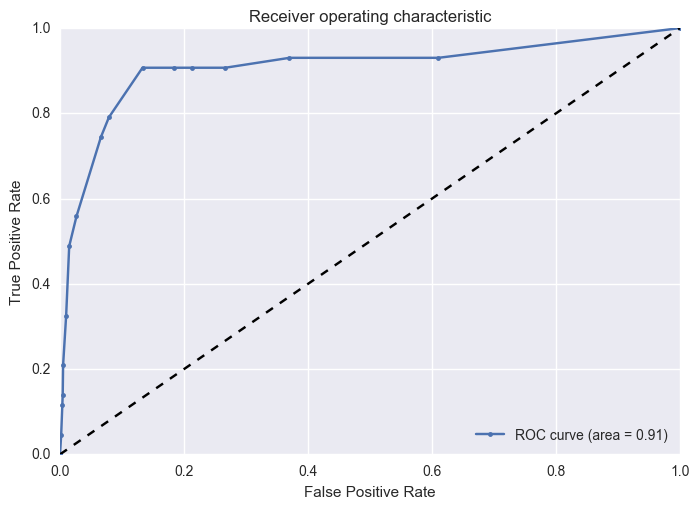

In [32]:
fpr,tpr,roc_auc, threshold, cfl = generate_auc(X, y, DecisionTreeClassifier, max_depth=best_depth, criterion='entropy')
rocPlot(fpr,tpr,'LR',roc_auc)
